In [9]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
from time import time
import pickle

import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import *

from sklearn import pipeline
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.kernel_approximation import (RBFSampler, Nystroem)
from sklearn.preprocessing import StandardScaler
import solution_ as sol
import inspect

### Data import and visualization  

In [10]:
# load data
train_x = np.loadtxt('train_x.csv', delimiter=',', skiprows=1)
train_y = np.loadtxt('train_y.csv', delimiter=',', skiprows=1)
test_x = np.loadtxt('test_x.csv', delimiter=',', skiprows=1)

print("Loaded {} training data points".format(train_x.shape[0]))


Loaded 15189 training data points


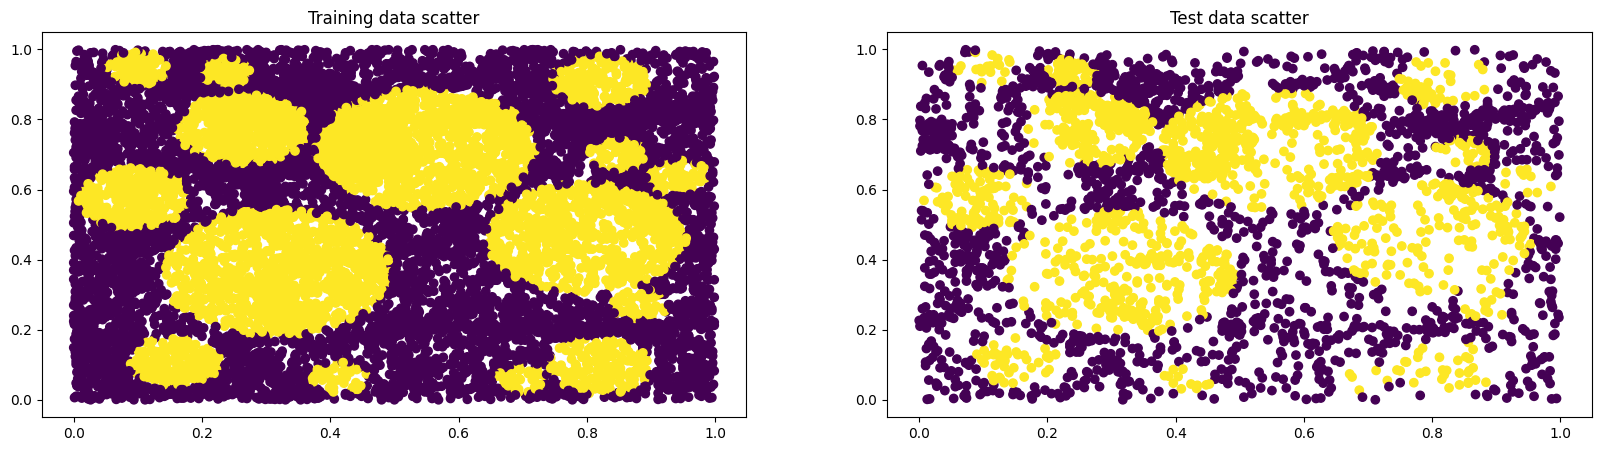

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.scatter(train_x[:,0], train_x[:,1], c=train_x[:,2])
ax1.set_title("Training data scatter")

ax2.scatter(test_x[:,0], test_x[:,1], c=test_x[:,2])
ax2.set_title("Test data scatter")
plt.show()

/home/stinicol/.local/lib/python3.8/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


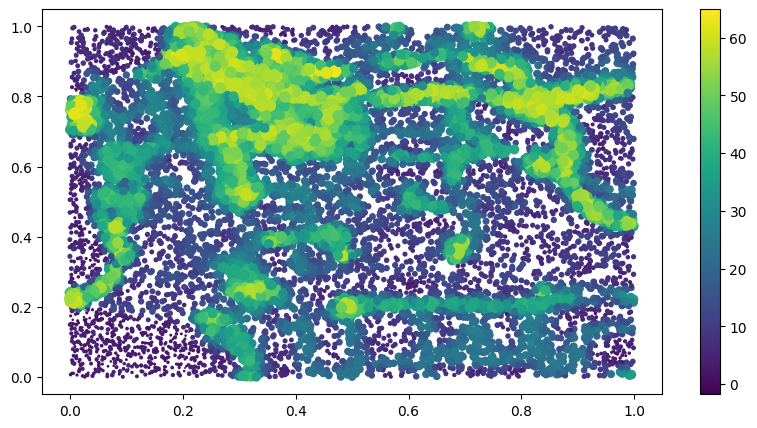

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
tcf = ax.scatter(train_x[:,0], train_x[:,1], train_y, c=train_y, cmap='viridis')
fig.colorbar(tcf)
plt.show()

In [13]:
from matplotlib.patches import Circle
def plot_circles(circle_data):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Iterate through the circle data and plot each circle
    for circle_info in circle_data:
        x, y, radius = circle_info
        circle = Circle((x, y), radius, fill=False, color='blue')
        ax.add_patch(circle)

    # Set the aspect ratio to be equal
    ax.set_aspect('equal', adjustable='box')

    # Calculate axis limits based on circle data
    x_min = np.min(circle_data[:, 0] - circle_data[:, 2])
    x_max = np.max(circle_data[:, 0] + circle_data[:, 2])
    y_min = np.min(circle_data[:, 1] - circle_data[:, 2])
    y_max = np.max(circle_data[:, 1] + circle_data[:, 2])
    
    # Adjust the axis limits to fit all circles
    ax.set_xlim(x_min - 1, x_max + 1)
    ax.set_ylim(y_min - 1, y_max + 1)

    # Display the plot
    plt.show()

### Create trainingand test sets of appropriate size

In [14]:
# Getting the data in the correct format
train_x_2D, train_x_AREA, test_x_2D, test_x_AREA = sol.extract_city_area_information(train_x, test_x)

In [15]:
# We split the training data into a further train and test split
train_x_2D_split, test_x_2D_split, train_y_split, test_y_split = train_test_split(train_x_2D, train_y, test_size=0.2, random_state=42)

# For the train split and the test split we determine the city area idx
train_x_split_AREA = sol.determine_city_area_idx(train_x_2D_split)
test_x_split_AREA = sol.determine_city_area_idx(test_x_2D_split)

# We reduce the trainset size to 1000
train_x_2D_split, train_y_split, train_x_split_AREA = sol.reduce_trainset_size(train_x_2D_split, train_y_split, train_x_split_AREA, trainset_size=1000)

In [16]:
kernel_dict = {
    # "RBF": [RBF],
    # "Matern": [Matern],
    # "RationalQuadratic": [RationalQuadratic],
    # "ExpSineSquared": [ExpSineSquared],
    # "RBF+matern": [RBF, Matern],
    # "RBF+RationalQuadratic": [RBF, RationalQuadratic],
    # "RBF+ExpSineSquared": [RBF, ExpSineSquared],
    # "Matern+RationalQuadratic": [Matern, RationalQuadratic],
    # "Matern+ExpSineSquared": [Matern, ExpSineSquared],
    "RationalQuadratic+ExpSineSquared": [RationalQuadratic, ExpSineSquared]
}

options_grid = {
    "kernel": list(kernel_dict.keys()),
    "length_scale": [0.01, 0.05, 0.1, 0.5, 1.0],
    "nu": [0.5],
    "noise_level": [1e-3, 1e-5, 0.1]
}

# scaler = StandardScaler().fit(train_x_2D_split)
# y_mean = train_y_split.mean()

In [17]:
kernel_configs = {
    'WhiteKernel': {
        'noise_level': 1.0,
        'noise_level_bounds': (1e-5, 1e5),
    },
    'RBF': {
        'length_scale': 1.0,
        'length_scale_bounds': (1e-5, 1e5),
    },
    'RationalQuadratic': {
        'length_scale': 1.0,
        'alpha': 1.0,
        'length_scale_bounds': (1e-5, 1e5),
        'alpha_bounds': (1e-5, 1e5),
    },
    'Matern': {
        'length_scale': 1.0,
        'length_scale_bounds': (1e-5, 1e5),
        'nu': 1.5,
    },
    'ExpSineSquared': {
        'length_scale': 1.0,
        'periodicity': 1.0,
        'length_scale_bounds': (1e-5, 1e5),
        'periodicity_bounds': (1e-5, 1e5),
    },
}

In [18]:
params_lst = list(ParameterGrid(options_grid))

scores = []

for params in params_lst:
    print("Running test on params: {}".format(params))
    
    try:
        # White kernel noise always gets included
        kernel = WhiteKernel(**kernel_configs['WhiteKernel'])
        
        for ker in kernel_dict[params['kernel']]:

            # Update kernel configs of the respective kernel for this iterations params
            # kernel_configs[ker.__name__].update(params)

            for key, value in params.items():
                # print(key)
                # print(kernel_configs[ker.__name__].items())
                if key in kernel_configs[ker.__name__]:
                    kernel_configs[ker.__name__][key] = value

            # Pass arguments to kernel and add to kernel

            print(kernel_configs[ker.__name__])
            kernel += ker(**kernel_configs[ker.__name__])

        gp_model = gp.GaussianProcessRegressor(kernel=kernel, alpha=0.01, n_restarts_optimizer=3, random_state=42)
        # feature_map = Nystroem(gamma=1, n_components=2, random_state=1)

        # gpr_pipeline = pipeline.Pipeline([
        #                             ("scaler", scaler),
        #                             # ("feature_map", feature_map),
        #                             ("gp", gp_model)
        #                             ])
        
        gp_model.fit(train_x_2D_split, train_y_split)
        
    except Exception as e:
        print("Failed to run test on params: {}".format(params))
        print(e)
        continue

    # Predict
    # pred_y = gp_model.predict(test_x_2D_split) + y_mean
    pred_y = gp_model.predict(test_x_2D_split)

    # Calculate score
    score = sol.cost_function(test_y_split, pred_y, test_x_split_AREA)
    scores.append((params, score))


Running test on params: {'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 0.001, 'nu': 0.5}
{'length_scale': 0.01, 'alpha': 1.0, 'length_scale_bounds': (1e-05, 100000.0), 'alpha_bounds': (1e-05, 100000.0)}
{'length_scale': 0.01, 'periodicity': 1.0, 'length_scale_bounds': (1e-05, 100000.0), 'periodicity_bounds': (1e-05, 100000.0)}
Running test on params: {'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 1e-05, 'nu': 0.5}
{'length_scale': 0.01, 'alpha': 1.0, 'length_scale_bounds': (1e-05, 100000.0), 'alpha_bounds': (1e-05, 100000.0)}
{'length_scale': 0.01, 'periodicity': 1.0, 'length_scale_bounds': (1e-05, 100000.0), 'periodicity_bounds': (1e-05, 100000.0)}
Running test on params: {'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 0.1, 'nu': 0.5}
{'length_scale': 0.01, 'alpha': 1.0, 'length_scale_bounds': (1e-05, 100000.0), 'alpha_bounds': (1e-05, 100000.0)}
{'length_scale': 0.01, 'period

In [20]:
# Show best score
best_score = min(scores, key=lambda x: x[1])
best_params = params_lst[params_lst.index(best_score[0])]

print("Best score: {}, best parameters: {}".format(best_score, best_params))

# print all scores

for score in scores:
    print(score)

Best score: ({'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 0.001, 'nu': 0.5}, 31538.37804342772), best parameters: {'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 0.001, 'nu': 0.5}
({'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 0.001, 'nu': 0.5}, 31538.37804342772)
({'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 1e-05, 'nu': 0.5}, 31538.37804342772)
({'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.01, 'noise_level': 0.1, 'nu': 0.5}, 31538.37804342772)
({'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.05, 'noise_level': 0.001, 'nu': 0.5}, 31538.37804342772)
({'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.05, 'noise_level': 1e-05, 'nu': 0.5}, 31538.37804342772)
({'kernel': 'RationalQuadratic+ExpSineSquared', 'length_scale': 0.05, 'noise_level': 0.1, 'nu': 0.5}, 31538.37804342772)
({'kernel':